# Sequence to Sequence models for sugar level prediction

For the first part, which make use of Recurrent Neural Networks, 
take a look at https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

The second part (to be done) will use the more advanced Transformer arquitecture. 

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MAE
from tensorflow.keras.metrics import MAPE, MSE
from tensorflow.keras.backend import clear_session
from tensorflow.keras.constraints import max_norm

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.yscale('log')
  plt.show()

## Data preprocessing

### Load datasets

Each dataset consits of sequences of `history`+`future` points, with 4 features: 

* time interval: days counted starting from the end of the `history` of the sequence. Thus, for points in the `history`, this feature takes negatuve values, while for points in the `future`, it's positive. 
* hour: hour of the day, divided by 24.
* day of week: day of the week in numbers ('Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6), divided by 7.
* sugar level: recorded sugar level, scaled with min/max scaler.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls '/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/'

noisy0.0_test.npy   noisy0.0_vad.npy
noisy0.0_train.npy  patient_measurements.csv


In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/"
noise=0.0
history = 100 
future = 12

train = np.load(os.path.join(root, "noisy%s_train.npy" %noise))
vad = np.load(os.path.join(root, "noisy%s_vad.npy" %noise))
test = np.load(os.path.join(root, "noisy%s_test.npy" %noise))

train_batch = 200
vad_batch = 200
test_batch = 200
num_epochs = 5

train_steps = train.shape[0] // train_batch
vad_steps = vad.shape[0] // train_batch
test_steps = test.shape[0] // test_batch

In [8]:
train.shape, vad.shape, test.shape

((70487, 112, 4), (9116, 112, 4), (8781, 112, 4))

###  Split data 

Each input sequence has both the features and labels (x and y, if you wish), so we have to separate them.

In [0]:
def split_features_labels(data, history, future):
    """
    Method to separate historic and future events (features and labels). 
    It returns input data for the encoder and decoder, and the output data 
    for the decoder. The input data for the decoder is just the output data 
    of the decoder, shifted by one step. 

    :param data: numpy ndarray with sequences of history+future points, and 4 attributes 
      (time_interval, hour_of_day, day_of_week, sugar_level). It has shape (?, history+future, 4)
    :param history: number of points for the features
    :param future: number of points for the labels
    :return three numpy arrays with the input data for the encoder (shape=(?, history, 4))
        and decoder (shape=(?, future+1, 1)), and the output data for the decoder
        (shape=(?, future+1, 1))
    """
    # split features and labels . Note that for the later, we only keep the 
    # feature with the sugar level, which constitutes our target
    yf, yl = data[:, :history], data[:, history:history+future, -1]
    
    # add start of sentence to labels (input to the decoder)
    yl_input = np.zeros(shape=(yl.shape[0], yl.shape[1]+1))
    yl_input[:, 1:] = yl
    # add end of sentence to labels (output of the decoder)
    yl_output = np.zeros(shape=(yl.shape[0], yl.shape[1]+1))
    yl_output[:, :-1] = yl
    
    # add new dimension at the end of input/output arrays to the decoder
    yl_input = yl_input[:, :, np.newaxis].astype(np.float32)
    yl_output = yl_output[:, :, np.newaxis].astype(np.float32)
    
    return (yf, yl_input), yl_output

In [0]:
train_data = split_features_labels(train, history, future)
vad_data = split_features_labels(vad, history, future)
test_data = split_features_labels(test, history, future)

In [11]:
train_data[0][0].shape, train_data[0][1].shape, train_data[1].shape

((70487, 100, 4), (70487, 13, 1), (70487, 13, 1))

### Make generators to feed the NN

In [0]:
def make_dataset(tensor):
    return tf.data.Dataset.from_tensor_slices(tensor)

def make_iterator(tensor, batch_size, num_epochs):
    dataset = make_dataset(tensor)
    return dataset.batch(batch_size).repeat(num_epochs)

In [0]:
train_gen = make_iterator(train_data, train_batch, num_epochs)
vad_gen = make_iterator(vad_data, vad_batch, num_epochs=1)
test_gen = make_iterator(test_data, test_batch, num_epochs=1)

## Seq2seq model with RNN

In [0]:
def encoder(latent_dim, num_features, mn):
    """
    Encoder with LSTM 

    :param latent_dim: dimension of the encoding vectors
    :param num_features: number of input features
    :param mn: max norm value
    :return encoder input and output states, and the inference model
    """
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_features))
    lstm_enc1 = LSTM(latent_dim, return_sequences=True, kernel_constraint=max_norm(mn))(encoder_inputs)
    encoder = LSTM(latent_dim, return_state=True, kernel_constraint=max_norm(mn))
    _, state_h, state_c = encoder(lstm_enc1)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # model to perform inference with the encoder
    encoder_model = Model(inputs=encoder_inputs, 
                          outputs=encoder_states, 
                          name='encoder_model_inference')

    return encoder_inputs, encoder_states, encoder_model

def decoder(encoder_states, latent_dim, mn):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param latent_dim: dimension of the decoding vectors
    :param mn: max norm value
    :return decoder input and output sequences, and the inference model
    """
    # Define an input sequence and process it.
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, 1))
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn))
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(1, activation='selu', kernel_constraint=max_norm(mn))
    decoder_outputs = decoder_dense(lstm_outputs)

    # model to perform inference with the decoder

    # inputs to cell and state (to be feed from the encoder last states, or others!)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs_inference, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    
    decoder_states_inference = [state_h, state_c]
    decoder_outputs_inference = decoder_dense(decoder_outputs_inference)
    decoder_model = Model(
        inputs=[decoder_inputs] + decoder_states_inputs,
        outputs=[decoder_outputs_inference] + decoder_states_inference,
        name='decoder_model_inference')
    
    return decoder_inputs, decoder_outputs, decoder_model

def seq2seq(history, future, latent_dim, num_features, mn):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param num_features: number of input features
    :param mn: max norm value
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_model = encoder(latent_dim, num_features, mn)
    print(encoder_model.summary())

    # decode
    decoder_inputs, decoder_outputs, decoder_model = decoder(encoder_states, latent_dim, mn)
    print(decoder_model.summary())

    # Training model
    training_model = Model(inputs=[encoder_inputs, decoder_inputs], 
                           outputs=decoder_outputs, 
                           name='seq2seq_training_model')
    print(training_model.summary())

    return training_model, encoder_model, decoder_model

Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          11000     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 50), (None, 50),  20200     
Total params: 31,200
Trainable params: 31,200
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________

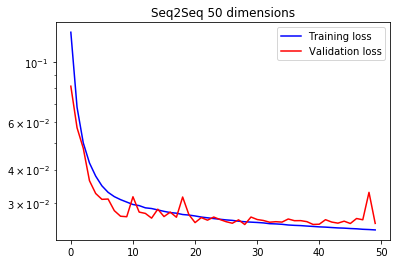

In [15]:
m, enc, dec = seq2seq(history, future, latent_dim=50, num_features=4, mn=1.0)
m.compile(optimizer='rmsprop', loss=MAE, metrics=[MSE])
h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=50, 
          validation_data=vad_data)
plot_train_history(h, 'Seq2Seq 50 dimensions')

Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         42000     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 100), (None, 100) 80400     
Total params: 122,400
Trainable params: 122,400
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
________________________________

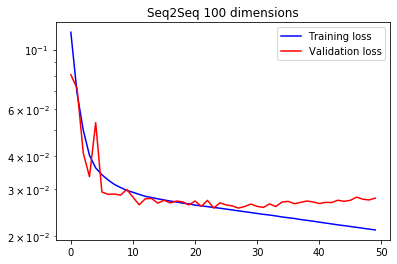

In [16]:
m, enc, dec = seq2seq(history, future, latent_dim=100, num_features=4, mn=1.0)
m.compile(optimizer='rmsprop', loss=MAE, metrics=[MSE])
h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=50, 
          validation_data=vad_data)
plot_train_history(h, 'Seq2Seq 100 dimensions')

Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          11000     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 50), (None, 50),  20200     
Total params: 31,200
Trainable params: 31,200
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________

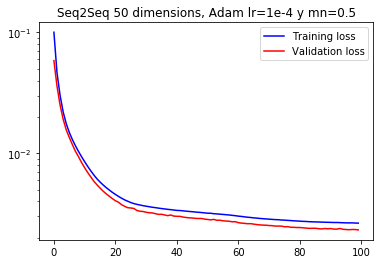

In [21]:
m, enc, dec = seq2seq(history, future, latent_dim=50, num_features=4, mn=.5)
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0), loss=MSE, metrics=[MAE, MAPE])
h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=100, 
          validation_data=vad_data)
plot_train_history(h, 'Seq2Seq 50 dimensions, Adam lr=1e-4 y mn=0.5')

Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          11000     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 50), (None, 50),  20200     
Total params: 31,200
Trainable params: 31,200
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________

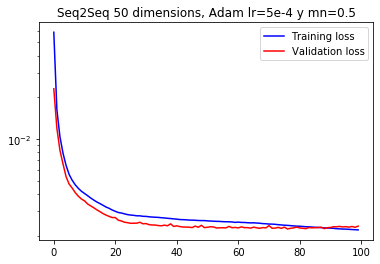

In [22]:
m, enc, dec = seq2seq(history, future, latent_dim=50, num_features=4, mn=.5)
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, clipvalue=1.0), loss=MSE, metrics=[MAE, MAPE])
h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=100, 
          validation_data=vad_data)
plot_train_history(h, 'Seq2Seq 50 dimensions, Adam lr=5e-4 y mn=0.5')

Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          11000     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 50), (None, 50),  20200     
Total params: 31,200
Trainable params: 31,200
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________

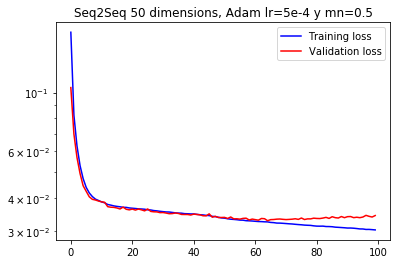

In [23]:
m, enc, dec = seq2seq(history, future, latent_dim=50, num_features=4, mn=.5)
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, clipvalue=1.0), loss=MAE, metrics=[MSE])
h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=100, 
          validation_data=vad_data)
plot_train_history(h, 'Seq2Seq 50 dimensions, Adam lr=5e-4 y mn=0.5')

Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          11000     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 50), (None, 50),  20200     
Total params: 31,200
Trainable params: 31,200
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________

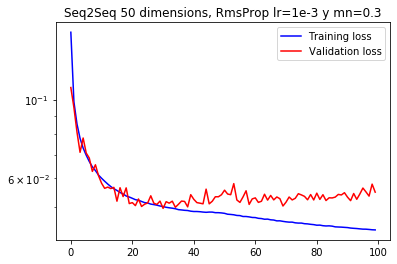

In [24]:
m, enc, dec = seq2seq(history, future, latent_dim=50, num_features=4, mn=.3)
m.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3, clipvalue=1.0), loss=MAE, metrics=[MSE])
h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=100, 
          validation_data=vad_data)
plot_train_history(h, 'Seq2Seq 50 dimensions, RmsProp lr=1e-3 y mn=0.3')

In [0]:
def encoder_simple(latent_dim, num_features, mn):
    """
    Encoder with LSTM 

    :param latent_dim: dimension of the encoding vectors
    :param num_features: number of input features
    :param mn: max norm value
    :return encoder input and output states, and the inference model
    """
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_features))
    #lstm_enc1 = LSTM(latent_dim, return_sequences=True, kernel_constraint=max_norm(mn))(encoder_inputs)
    encoder = LSTM(latent_dim, return_state=True, kernel_constraint=max_norm(mn))
    _, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # model to perform inference with the encoder
    encoder_model = Model(inputs=encoder_inputs, 
                          outputs=encoder_states, 
                          name='encoder_model_inference')

    return encoder_inputs, encoder_states, encoder_model

def decoder(encoder_states, latent_dim, mn):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param latent_dim: dimension of the decoding vectors
    :param mn: max norm value
    :return decoder input and output sequences, and the inference model
    """
    # Define an input sequence and process it.
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, 1))
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn))
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(1, activation='selu', kernel_constraint=max_norm(mn))
    decoder_outputs = decoder_dense(lstm_outputs)

    # model to perform inference with the decoder

    # inputs to cell and state (to be feed from the encoder last states, or others!)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs_inference, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    
    decoder_states_inference = [state_h, state_c]
    decoder_outputs_inference = decoder_dense(decoder_outputs_inference)
    decoder_model = Model(
        inputs=[decoder_inputs] + decoder_states_inputs,
        outputs=[decoder_outputs_inference] + decoder_states_inference,
        name='decoder_model_inference')
    
    return decoder_inputs, decoder_outputs, decoder_model

def seq2seq_simple(history, future, latent_dim, num_features, mn):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param num_features: number of input features
    :param mn: max norm value
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_model = encoder_simple(latent_dim, num_features, mn)
    print(encoder_model.summary())

    # decode
    decoder_inputs, decoder_outputs, decoder_model = decoder(encoder_states, latent_dim, mn)
    print(decoder_model.summary())

    # Training model
    training_model = Model(inputs=[encoder_inputs, decoder_inputs], 
                           outputs=decoder_outputs, 
                           name='seq2seq_training_model')
    print(training_model.summary())

    return training_model, encoder_model, decoder_model

Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 50), (None, 50),  11000     
Total params: 11,000
Trainable params: 11,000
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50)]         0             

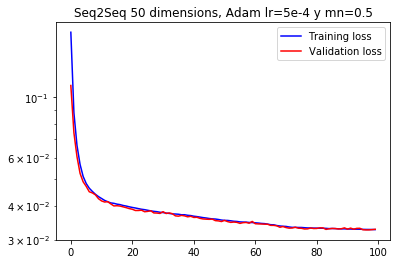

In [28]:
m, enc, dec = seq2seq_simple(history, future, latent_dim=50, num_features=4, mn=.5)
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, clipvalue=1.0), loss=MAE, metrics=[MSE])
h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=100, 
          validation_data=vad_data)
plot_train_history(h, 'Seq2Seq 50 dimensions, Adam lr=5e-4 y mn=0.5')